# Ocean BRDF Benchmark

In [1]:
import json
import os
import drjit as dr
import mitsuba as mi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from drjit import *

In [2]:
FOAM=0
GLINT=1
UNDERLIGHT=3
REFLECTANCE=4


SELECTED_CHANNEL = GLINT
SELECTED_WAVELENGTH = 2.2

## Loading Data

First, we load the data from the data files. This JSON file is a dictionary which contains:

* (The wavelength at which the data was generated)
* (The wind speed at which the data was generated)
* Oceanic properties such as salinity, chlorinity and pigmentation
* The data itself, consisting of incoming directions, for which multiple outgoing directions have been evaluated

In [3]:
wind_speeds = [0.1, 1, 10, 37]

solar_azimuth = 0
view_azimuth = 0
wind_direction = 0
salinity = 0
chlorinity = 0
pigmentation = 0

def load_data():
    df = pd.DataFrame(columns=['solar_zenith', 'view_zenith', 'wind_speed', 'foam', 'glint', 'underlight', 'reflectance', 'mitsuba_channel', 'relative_error', 'absolute_error'])
    benchmark_data = {}
    settings = {}
    for wind_speed in wind_speeds:
        with open(f'data/data_{wind_speed}ms_{SELECTED_WAVELENGTH}.json') as file:
            data = json.load(file)

            # Obtain the other parameters from the data
            solar_azimuth = data['solar_azimuth']
            view_azimuth = data['view_azimuth']
            wind_direction = data['wind_direction']
            salinity = data['salinity']
            chlorinity = data['chlorinity']
            pigmentation = data['pigmentation']

            settings[wind_speed] = {
                'solar_azimuth': solar_azimuth,
                'view_azimuth': view_azimuth,
                'wind_direction': wind_direction,
                'salinity': salinity,
                'chlorinity': chlorinity,
                'pigmentation': pigmentation
            }

            # Solar Data
            solar_data = data['data']

            # Construct the data points that have to be plotted
            benchmark_data[wind_speed] = {}
            for solar_key, solar_key_data in solar_data.items():
                view_benchmarks = []
                for _, view_key_data in solar_key_data.items():
                    view_zenith = view_key_data['outgoing_zenith']
                    foam = view_key_data['foam']
                    glint = view_key_data['glint']
                    underlight = view_key_data['water']
                    reflectance = view_key_data['total']

                    # Set the dataframe
                    df = pd.concat([df, pd.DataFrame({
                        'solar_zenith': [float(solar_key)], 
                        'view_zenith': [view_zenith], 
                        'wind_speed': [wind_speed], 
                        'foam': [foam], 
                        'glint': [glint], 
                        'underlight': [underlight], 
                        'reflectance': [reflectance],
                        'mitsuba_channel': [np.nan],
                        'relative_error': [np.nan]
                    })], ignore_index=True)

                    # Benchmark Data
                    view_benchmarks.append(view_zenith)
                benchmark_data[wind_speed][solar_key] = view_benchmarks
                    

    return df, benchmark_data, settings               

In [4]:
df, benchmark_data, settings = load_data()

/var/folders/2y/rhmx4lpx7yj6c8p50ldw1x_c0000gp/T/ipykernel_82888/824976016.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame({


## Computing Benchmark

Once the data is loaded, we can compute the reflectance for each required benchmark setting. This involves constructing a vector for each solar zenith, consisting of all the viewing zeniths. 

In [5]:
# Load Mitsuba
mi.set_variant('llvm_ad_rgb_double')


In [6]:
# Helper to go from spherical to Euclidean coordinates
def sph_to_eucl(theta, phi):
    st, ct = dr.sincos(theta)
    sp, cp = dr.sincos(phi)
    return mi.Vector3f(cp * st, sp * st, ct)

# Helper function to compute the relative error
def relative_error(x, y):
    if y == 0:
        if x < 1e-6:
            return 0
        return x - y
    return (x - y) / y

# Helper function to compute the absolute error
def absolute_error(x, y):
    return np.abs(x - y)

In [7]:
# Channel Conversion 
def convert_channel(channel):
    if channel == FOAM:
        return 'foam'
    elif channel == GLINT:
        return 'glint'
    elif channel == UNDERLIGHT:
        return 'underlight'
    elif channel == REFLECTANCE:
        return 'reflectance'
    else:
        return 'unknown'

In [8]:
from tqdm import tqdm

# TODO: Make this multi-threaded
def benchmark():
    for wind_speed in wind_speeds:
        # Collect the current settings
        ws_settings = settings[wind_speed]
        solar_azimuth = ws_settings['solar_azimuth']
        view_azimuth = ws_settings['view_azimuth']
        wind_direction = ws_settings['wind_direction']
        salinity = ws_settings['salinity']
        chlorinity = ws_settings['chlorinity']
        pigmentation = ws_settings['pigmentation']

        # Benchmarking
        ws_benchmark_data = benchmark_data[wind_speed]
        progress = tqdm(ws_benchmark_data.items(), desc=f'Wind Speed: {wind_speed} m/s')
        for solar_zenith, viewing_zeniths in ws_benchmark_data.items():
            solar_zenith = float(solar_zenith)

            # Create the surface interaction
            si = dr.zeros(mi.SurfaceInteraction3f)
            
            # Create the incident direction
            si.wi = sph_to_eucl(solar_zenith, solar_azimuth)

            min_zenith = np.min(viewing_zeniths)
            max_zenith = np.max(viewing_zeniths)

            zenith_array = dr.linspace(mi.Float, min_zenith, max_zenith, len(viewing_zeniths))
            azimuth_array = dr.full(mi.Float, view_azimuth)
        
            # Create data points
            bm_zeniths, bm_azimuths = dr.meshgrid(
                zenith_array,
                azimuth_array
            )
            wo = sph_to_eucl(bm_zeniths, bm_azimuths)

            # Construct BxDF
            bsdf = mi.load_dict({
                'type': 'oceanic_legacy',
                'channel': SELECTED_CHANNEL,
                'wavelength': SELECTED_WAVELENGTH,
                'wind_speed': wind_speed,
                'wind_direction': wind_direction,
                'chlorinity': chlorinity,
                'pigmentation': pigmentation
            })

            # Evaluate the data points for the selected channel
            benchmark_eval = bsdf.eval(mi.BSDFContext(), si, wo)

            # Conversion to readable format and NumPy
            benchmark_eval = (np.array(benchmark_eval))[:,0]

            # Update the dataframe with the Mitsuba data
            for i, benchmark_eval_data in enumerate(benchmark_eval):
                df.loc[(df['solar_zenith'] == solar_zenith) & (df['view_zenith'] == viewing_zeniths[i]) & (df['wind_speed'] == wind_speed), 'mitsuba_channel'] = benchmark_eval_data

                # Compute the relative error in the reference and mitsuba channels
                channel_name = convert_channel(SELECTED_CHANNEL)

                ref_channel = df.loc[(df['solar_zenith'] == solar_zenith) & (df['view_zenith'] == viewing_zeniths[i]) & (df['wind_speed'] == wind_speed), channel_name].values[0]
                mitsuba_channel = df.loc[(df['solar_zenith'] == solar_zenith) & (df['view_zenith'] == viewing_zeniths[i]) & (df['wind_speed'] == wind_speed), 'mitsuba_channel'].values[0]

                # Compute the relative error
                relative_err = relative_error(mitsuba_channel, ref_channel)

                # Compute the absolute error
                absolute_err = absolute_error(mitsuba_channel, ref_channel)

                # Update the dataframe with the relative and absolute error
                df.loc[(df['solar_zenith'] == solar_zenith) & (df['view_zenith'] == viewing_zeniths[i]) & (df['wind_speed'] == wind_speed), 'relative_error'] = relative_err
                df.loc[(df['solar_zenith'] == solar_zenith) & (df['view_zenith'] == viewing_zeniths[i]) & (df['wind_speed'] == wind_speed), 'absolute_error'] = absolute_err

            # Update progress bar
            progress.update(1)
        progress.close()

benchmark()
        

Wind Speed: 0.1 m/s:   0%|          | 0/18 [00:00<?, ?it/s]

Wind Speed: 37 m/s: 100%|██████████| 18/18 [00:00<00:00, 20.96it/s]


In [9]:
# Add a column 'theta_i' in Latex format for the solar zenith in degrees
df['t_i'] = df['solar_zenith'].apply(lambda x: f'{np.rad2deg(x):.2f}')
df['t_o'] = df['view_zenith'].apply(lambda x: f'{np.rad2deg(x):.0f}')
df

,solar_zenith,view_zenith,wind_speed,foam,glint,underlight,reflectance,mitsuba_channel,relative_error,absolute_error,t_i,t_o
0,0.00000,0.000000,0.1,0.0000,2.37505,0.0,2.37505,2.375114e+00,0.000027,0.000064,0.00,0
1,0.00000,0.087266,0.1,0.0000,0.56277,0.0,0.56277,5.627868e-01,0.000030,0.000017,0.00,5
2,0.00000,0.174533,0.1,0.0000,0.01899,0.0,0.01899,1.898895e-02,-0.000055,0.000001,0.00,10
3,0.00000,0.261799,0.1,0.0000,0.00012,0.0,0.00012,1.175402e-04,-0.020498,0.000002,0.00,15
4,0.00000,0.349066,0.1,0.0000,0.00000,0.0,0.00000,4.195414e-08,0.000000,0.0,0.00,20
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,1.48353,1.134464,37.0,0.0635,0.00000,0.0,0.06350,7.048293e-07,0.000000,0.000001,85.00,65
1292,1.48353,1.221730,37.0,0.0635,0.00000,0.0,0.06350,1.070071e-09,0.000000,0.0,85.00,70
1293,1.48353,1.308997,37.0,0.0635,0.00000,0.0,0.06350,2.652082e-15,0.000000,0.0,85.00,75
1294,1.48353,1.396263,37.0,0.0635,0.00000,0.0,0.06350,3.859055e-28,0.000000,0.0,85.00,80


# Plotting Results

If the benchmark data has been successfully added to the dataframe, we can start plotting the data in a manner that is informative and readable

In [10]:
# Split the dataframe in X dataframes for each wind speed
df_split = {wind_speed: df[df['wind_speed'] == wind_speed] for wind_speed in wind_speeds}

In [11]:
# Colors
red_palette = []
yellow_palette = []
green_palette = []
blue_palette = []
palettes = [red_palette, yellow_palette, green_palette, blue_palette]

# Add to palettes
red_palette.extend(['#E06666'] * len(df_split[0.1]))
green_palette.extend(['#9DBB53'] * len(df_split[0.1]))
blue_palette.extend(['#78C7FF'] * len(df_split[0.1]))
yellow_palette.extend(['#FFCA46'] * len(df_split[0.1]))

palettes = [red_palette, yellow_palette, green_palette, blue_palette]

Plotting:   0%|          | 0/4 [00:00<?, ?it/s]

Plotting: 100%|██████████| 4/4 [00:13<00:00,  3.48s/it]


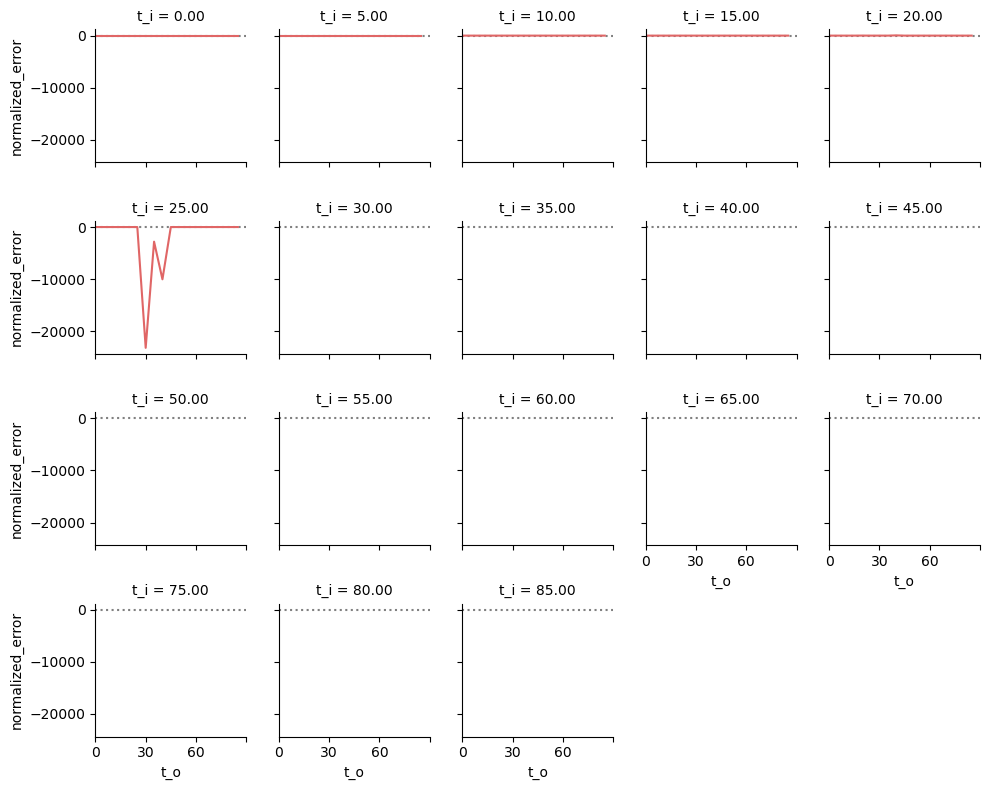

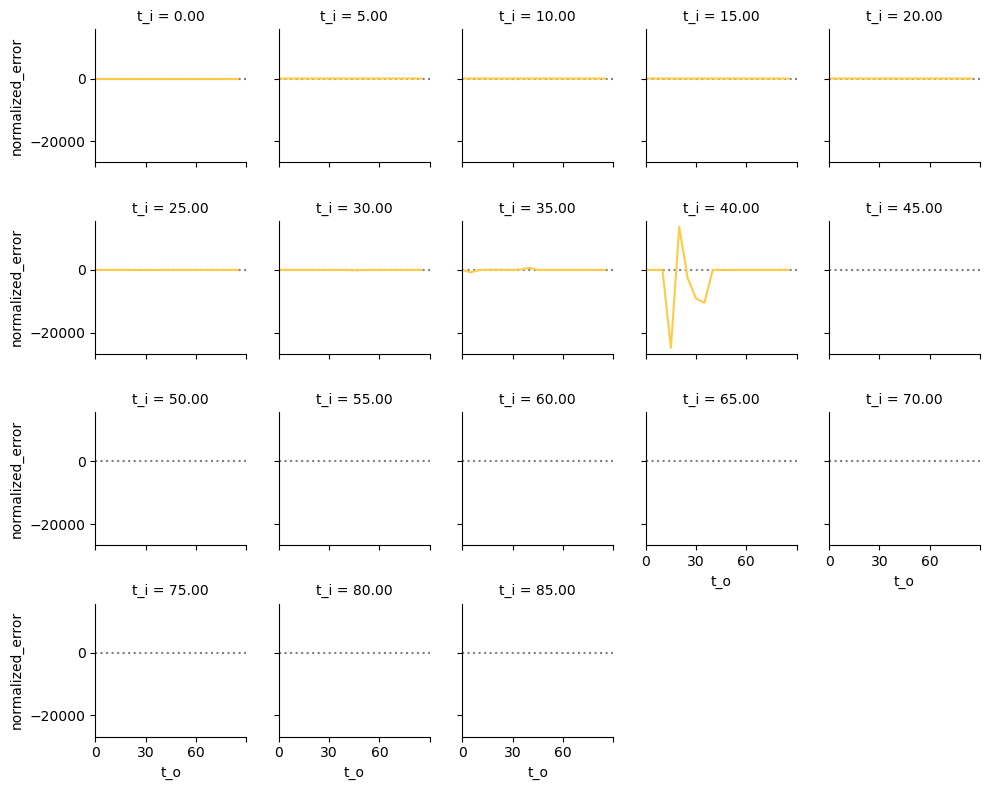

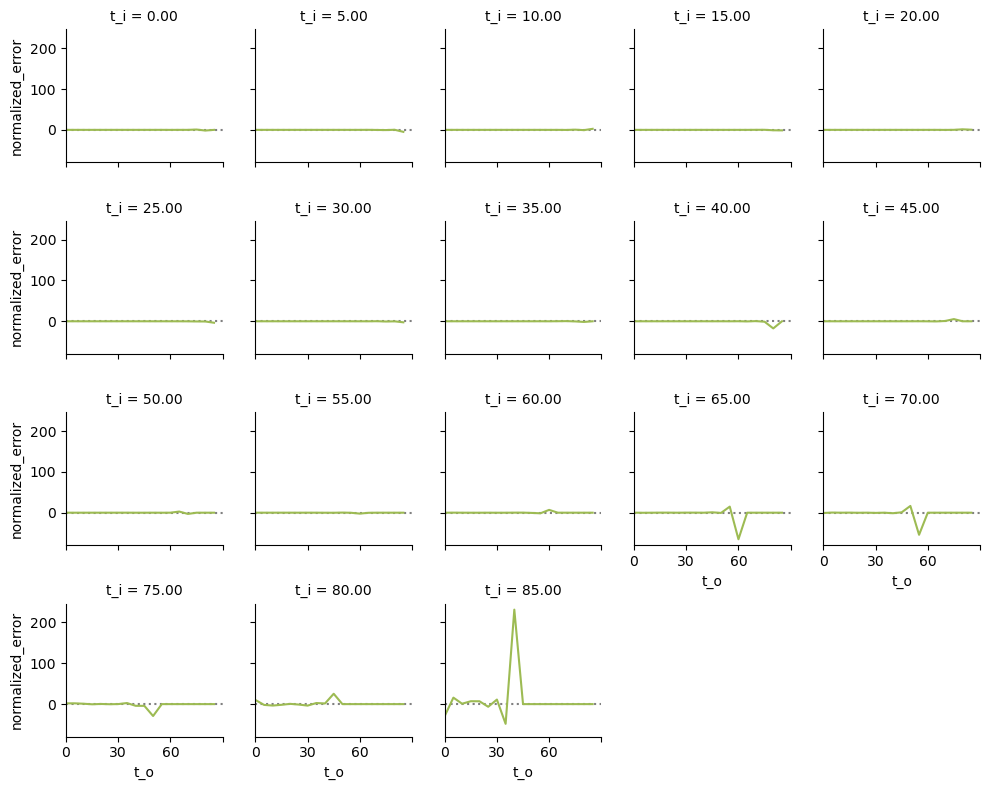

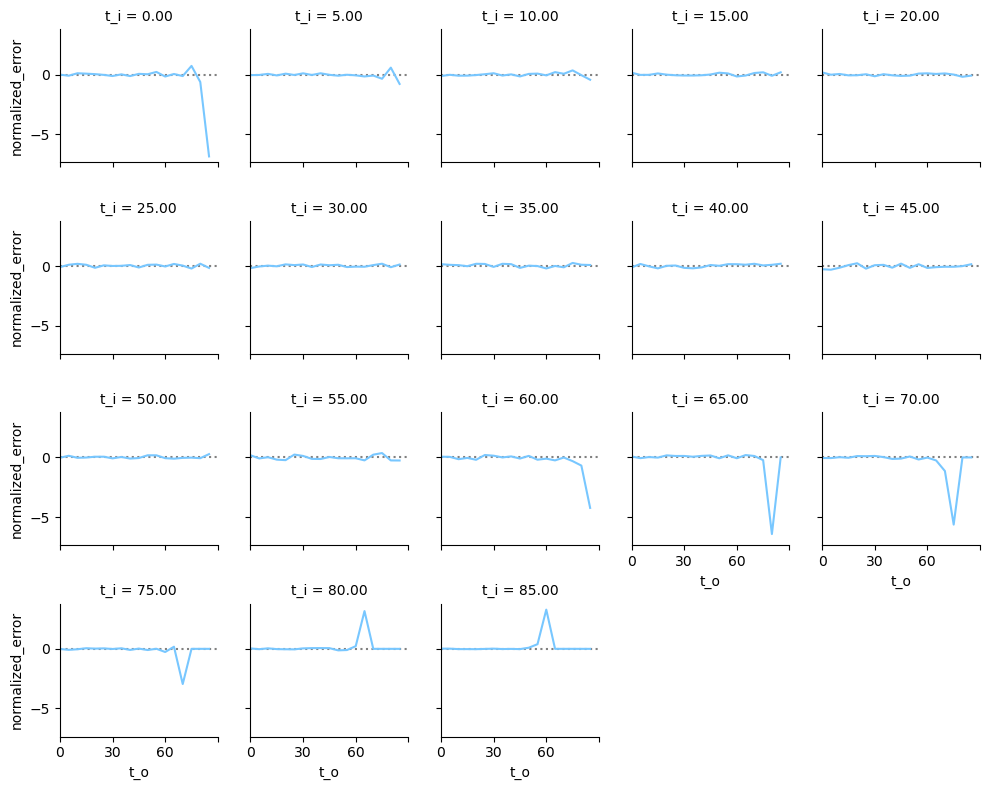

In [12]:
progress = tqdm(wind_speeds, desc='Plotting')

class ChainedAssignent:

    """ Context manager to temporarily set pandas chained assignment warning. Usage:
    
        with ChainedAssignment():
             blah  
             
        with ChainedAssignment('error'):
             run my code and figure out which line causes the error! 
    
    """

    def __init__(self, chained = None):
        acceptable = [ None, 'warn','raise']
        assert chained in acceptable, "chained must be in " + str(acceptable)
        self.swcw = chained

    def __enter__( self ):
        self.saved_swcw = pd.options.mode.chained_assignment
        pd.options.mode.chained_assignment = self.swcw
        return self

    def __exit__(self, *args):
        pd.options.mode.chained_assignment = self.saved_swcw

index = 0
for wind_speed in wind_speeds:
    with ChainedAssignent():
        # Get the data and the palette
        palette = palettes[index]
        frame = df_split[wind_speed]

        # Add a new column to the dataframe that contains the normalized error
        frame['normalized_error'] = frame['relative_error']

        for solar_zenith in df['solar_zenith'].unique():
            mask = frame['solar_zenith'] == solar_zenith
            normalization_constant = frame.loc[mask]['reflectance'].max()
            frame.loc[mask, 'normalized_error'] /= normalization_constant   

        # Initialize the grid
        grid = sns.FacetGrid(frame, col='t_i', hue='t_i', palette=palette,
                                col_wrap=5, height=2.0)
        
        # Draw the reference line
        grid.refline(y=0, linestyle=':')

        # Draw a line plot to show the trajectory of each relative error, but space 
        # the relative error such that it is defined over the view zenith
        grid.map(sns.lineplot, 't_o', 'normalized_error', errorbar=None)

        # Adjust the tick positions and labels
        grid.set(xticks=np.arange(0, 19, 6),
                xlim=(0, 18))

        # Adjust the arrangement of the plots
        grid.fig.tight_layout(w_pad=2)

        # Save the plot
        grid.savefig(f'plots/test/relative_error_{wind_speed}ms_{SELECTED_WAVELENGTH}.pdf')

        index += 1
        progress.update(1)
progress.close()

In [13]:
# Just a test plot
test_solar_zenith = 0
test_wind_speed = 0.1

test_frame = df[(df['solar_zenith'] == test_solar_zenith) & (df['wind_speed'] == test_wind_speed)]
test_frame

,solar_zenith,view_zenith,wind_speed,foam,glint,underlight,reflectance,mitsuba_channel,relative_error,absolute_error,t_i,t_o
0,0.0,0.000000,0.1,0.0,2.37505,0.0,2.37505,2.375114e+00,0.000027,0.000064,0.00,0
1,0.0,0.087266,0.1,0.0,0.56277,0.0,0.56277,5.627868e-01,0.000030,0.000017,0.00,5
2,0.0,0.174533,0.1,0.0,0.01899,0.0,0.01899,1.898895e-02,-0.000055,0.000001,0.00,10
3,0.0,0.261799,0.1,0.0,0.00012,0.0,0.00012,1.175402e-04,-0.020498,0.000002,0.00,15
4,0.0,0.349066,0.1,0.0,0.00000,0.0,0.00000,4.195414e-08,0.000000,0.0,0.00,20
5,0.0,0.436332,0.1,0.0,0.00000,0.0,0.00000,6.792603e-13,0.000000,0.0,0.00,25
6,0.0,0.523599,0.1,0.0,0.00000,0.0,0.00000,4.425698e-19,0.000000,0.0,0.00,30
7,0.0,0.610865,0.1,0.0,0.00000,0.0,0.00000,9.526538e-27,0.000000,0.0,0.00,35
8,0.0,0.698132,0.1,0.0,0.00000,0.0,0.00000,5.106637e-36,0.000000,0.0,0.00,40
9,0.0,0.785398,0.1,0.0,0.00000,0.0,0.00000,4.700122e-47,0.000000,0.0,0.00,45


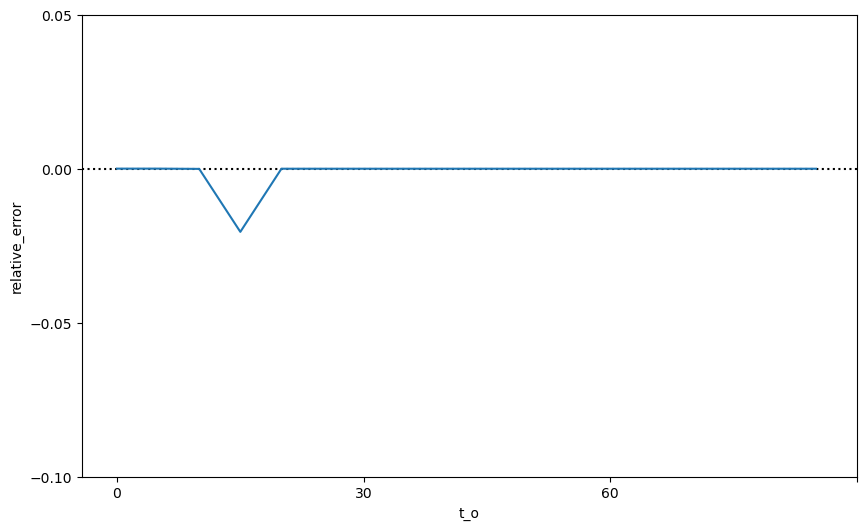

In [14]:
# Create a plot for the relative test error
plt.figure(figsize=(10, 6))

# Draw the reference line
plt.axhline(0, color='black', linestyle=':')

# Draw the relative error
sns.lineplot(data=test_frame, x='t_o', y='relative_error')

# Adjust the tick positions and labels
plt.xticks(np.arange(0, 19, 6))
plt.yticks(np.arange(-0.1, 0.1, 0.05))

plt.show()